In [1]:
import torch
use_gpu = True if torch.cuda.is_available() else False
torch.manual_seed(0)
import numpy as np
np.random.seed(0)
torch.backends.cudnn.benchmark = True

In [2]:
#this model outputs 256 x 256 pixel images
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celebAHQ-256',
                       pretrained=True, useGPU=use_gpu)

Using cache found in /home/extra/marvin852316497/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


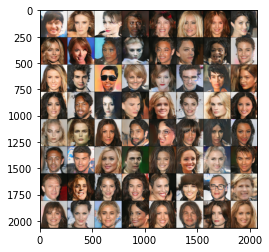

In [3]:
num_images = 64
noise, _ = model.buildNoiseData(num_images)
with torch.no_grad():
    generated_images = model.test(noise)

# let's plot these images using torchvision and matplotlib
import matplotlib.pyplot as plt
import torchvision
grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())


In [4]:
src_img_idx = 8
target_img_idx = 31
import numpy as np
from torchvision.utils import make_grid

In [5]:
noise1 = noise[src_img_idx]
noise2 = noise[target_img_idx]
out_GAN = []
L = 9
for t in np.linspace(0,1,L):
    t = float(t)  # cast numpy object to primative type
    z_inter = torch.tensor([(1-t)*a + t*b for a,b in zip(noise1, noise2)])
    GAN_image = model.test(z_inter.unsqueeze(0))

    GAN_image = GAN_image.numpy().clip(-0.5, 0.5) + 0.5
    out_GAN.append(GAN_image)

In [6]:
%matplotlib inline
def show(img, fig_size=(12,8)):
    npimg = img.numpy()
    fig = plt.figure(figsize=fig_size, dpi=100) 
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')    

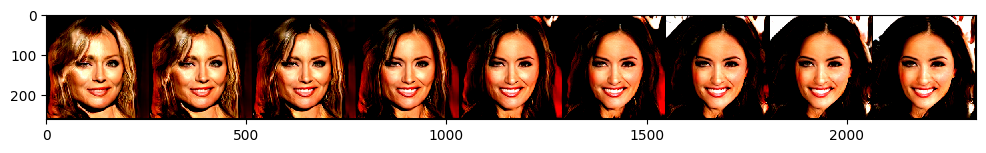

In [7]:
img_size = (256,256)
final_GAN = torch.stack([torch.Tensor(im).reshape(3,*img_size) for im in out_GAN])
show(make_grid(final_GAN.clamp(min=-1, max=1), scale_each=True, 
        normalize=True,
        nrow=L,
        range=(0.,1.)))

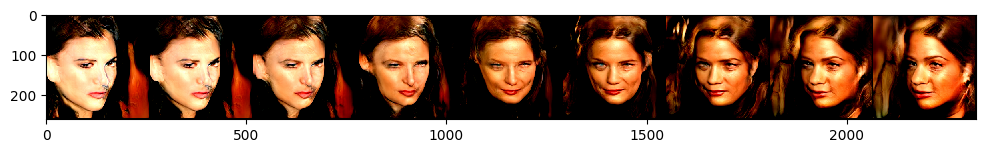

In [9]:
src_img_idx = 27
target_img_idx = 23

noise1 = noise[src_img_idx]
noise2 = noise[target_img_idx]
out_GAN = []
L = 9
for t in np.linspace(0,1,L):
    t = float(t)  # cast numpy object to primative type
    z_inter = torch.tensor([(1-t)*a + t*b for a,b in zip(noise1, noise2)])
    GAN_image = model.test(z_inter.unsqueeze(0))

    GAN_image = GAN_image.numpy().clip(-0.5, 0.5) + 0.5
    out_GAN.append(GAN_image)
    
img_size = (256,256)
final_GAN = torch.stack([torch.Tensor(im).reshape(3,*img_size) for im in out_GAN])
show(make_grid(final_GAN.clamp(min=-1, max=1), scale_each=True, 
        normalize=True,
        nrow=L,
        range=(0.,1.)))

In [10]:
import torch.nn.functional as F

In [11]:
print(noise1.shape)

torch.Size([512])


In [12]:
iters = 1
eta = 1
image = generated_images[src_img_idx]
z_0 = torch.zeros((1, noise1.shape[0]), requires_grad=True)
print(z_0.shape)

torch.Size([1, 512])


In [15]:
import copy
from tqdm.auto import tqdm
def iterative_atk(noise, eta=1e-9, iters=500, eps=1e-4):
    image = model.test(noise)
    print("noise norm:\t", noise.norm().item())
    reconstruct_imgs = []
    z_0 = torch.zeros((1, noise1.shape[0]), requires_grad=True)
    pre_loss = 10000000
    trange = tqdm(range(iters))
    for i in trange:
        z_0.retain_grad()
        if z_0.grad is not None:
            z_0.grad.detach_()
            z_0.grad.zero_()

        loss_r1 = F.mse_loss(image, model.netG(z_0))
        loss_r1.backward()
        cur_grad = z_0.grad
        z_0 = z_0 - eta*cur_grad
        reconstruct_imgs.append(model.test(z_0).squeeze(0))
#         print("======================")
#         print("loss_r1:\t", loss_r1.item())
#         print("z0 norm:\t", z_0.norm().item())
#         print("cosine similarity:\t", F.cosine_similarity(z_0.reshape(-1), noise.reshape(-1), dim=0).item())
#         print("grad norm:\t", eta*cur_grad.norm().item())
#         print(pre_loss - loss_r1.item())
        trange.set_postfix({"loss_r1":loss_r1.item(), "z0_norm":z_0.norm().item(), "cs":F.cosine_similarity(z_0.reshape(-1), noise.reshape(-1), dim=0).item(), "grad_norm":eta*cur_grad.norm().item(), "residual":abs(pre_loss - loss_r1.item())})
        if(abs(pre_loss - loss_r1.item())  < eps):
            break
        pre_loss = loss_r1.item()

    plt.imshow(image.squeeze(0).permute(1,2,0))
    plt.show()
    print(torch.stack(reconstruct_imgs,0).shape)
    reconstruct_imgs_10 = reconstruct_imgs[::max(len(reconstruct_imgs)//10,1)]
    show(make_grid(torch.stack(reconstruct_imgs_10,0).clamp(min=-1., max=1.), scale_each=True, 
            normalize=True,
            nrow=len(reconstruct_imgs_10),
            range=(0.,1.)))
    return reconstruct_imgs

noise norm:	 23.46847152709961


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


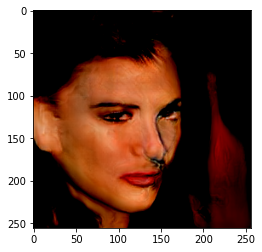

torch.Size([247, 3, 256, 256])


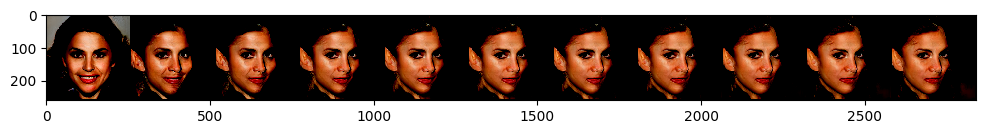

In [16]:
reconstruct_imgs = iterative_atk(noise[src_img_idx].unsqueeze(0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


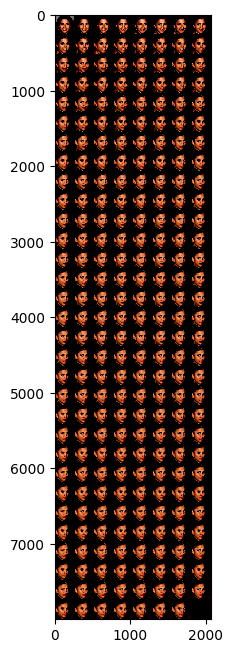

In [17]:
show(make_grid(reconstruct_imgs))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


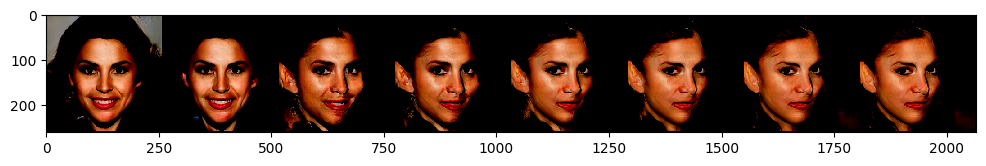

In [18]:
show(make_grid(torch.stack([reconstruct_imgs[0],reconstruct_imgs[1],reconstruct_imgs[21],reconstruct_imgs[40], reconstruct_imgs[80], reconstruct_imgs[-70],reconstruct_imgs[-10], reconstruct_imgs[-1]], 0)))

In [19]:
from typing import List, Tuple
from numba import jit
# Compute the L2 metric for the transportation cost. Can probably be vectorized to run faster.
@jit("float64[:,:](int64,int64,int64[:,:,:])",nopython=True)
def _generate_metric(height, width, grid):
    # Could probably inpmprove runtime using vectorized code
    C = np.zeros((height*width, height*width))
    i = 0
    j = 0
    for y1 in range(width):
        for x1 in range(height):
            for y2 in range(width):
                for x2 in range(height):
                    C[i,j] = np.square(grid[x1,y1,:] - grid[x2,y2,:]).sum()
                    j += 1
            j = 0
            i += 1
    return C

def generate_metric(im_size: Tuple[int]) -> np.ndarray:
    """
    Computes the Euclidean distances matrix
    
    Arguments:
        im_size {Tuple[int]} -- Size of the input image (height, width)
    
    Returns:
        np.ndarray -- distances matrix
    """
    grid = np.meshgrid(*[range(x) for x in im_size])
    grid = np.stack(grid,-1)
    return _generate_metric(im_size[0], im_size[1], grid)

In [20]:
# Find interpolation given the transportation plan. Can probably be vectorized to run faster.
@jit("float64[:,:](int64,int64,float64[:,:,:,:],float32)",nopython=True)
def generate_interpolation(height, width, plan, t):
    c = np.zeros((height+1, width+1))
    for y1 in range(width):
        for x1 in range(height):
            for y2 in range(width):
                for x2 in range(height):
                    new_loc_x = (1-t)*x1 + t*x2
                    new_loc_y = (1-t)*y1 + t*y2
                    p = new_loc_x - int(new_loc_x)
                    q = new_loc_y - int(new_loc_y)
                    c[int(new_loc_x),int(new_loc_y)] += (1-p)*(1-q)*plan[x1,y1,x2,y2]
                    c[int(new_loc_x)+1,int(new_loc_y)] += p*(1-q)*plan[x1,y1,x2,y2]
                    c[int(new_loc_x),int(new_loc_y)+1] += (1-p)*q*plan[x1,y1,x2,y2]
                    c[int(new_loc_x)+1,int(new_loc_y)+1] += p*q*plan[x1,y1,x2,y2]
    c = c[:height,:width] #* (I1_count*(1-t) + I2_count*t)
    return c

def sinkhorn(a: np.ndarray, b: np.ndarray, C: np.ndarray, height: int, width: int, 
             epsilon: float, threshold: float=1e-7) -> np.ndarray:
    """Computes the sinkhorn algorithm naively, using the CPU.
    
    Arguments:
        a {np.ndarray} -- the first distribution (image), normalized, and shaped to a vector of size height*width.
        b {np.ndarray} -- the second distribution (image), normalized, and shaped to a vector of size height*width.
        C {np.ndarray} -- the distances matrix
        height {int} -- image height
        width {int} -- image width
        epsilon {float} -- entropic regularization parameter
    
    Keyword Arguments:
        threshold {float} -- convergence threshold  (default: {1e-7})
    
    Returns:
        np.ndarray -- the entropic regularized transportation plan, pushing distribution a to b.
    """
    K = np.exp(-C/epsilon)
    v = np.random.randn(*a.shape)
    i = 0
    while True:
        u = a/(K.dot(v))
        v = b/(K.T.dot(u))
        i += 1
        if i % 50 == 0:
            convergence = np.square(np.sum(u.reshape(-1, 1) * K * v.reshape(1,-1), axis=1) - a).sum()
            if convergence < threshold:
                print(f"Iteration {i}. Sinkhorn convergence: {convergence:.2E} (Converged!)")
                break
            else:
                print(f"Iteration {i}. Sinkhorn convergence: {convergence:.2E} ( > {threshold})")

    P = u.reshape(-1, 1) * K * v.reshape(1,-1)
    P = P.reshape(height, width, height, width)
    return P

def preprocess_Q(Q: np.ndarray, max_val: float=None, Q_counts: np.ndarray=None) -> Tuple[np.ndarray, float, np.ndarray]:
    """ Preprocess (normalize) input images before computing their barycenters
    
    Arguments:
        Q {np.ndarray} -- Input images. Every image should reshaped to a column in Q.
    
    Keyword Arguments:
        max_val {float} -- The maximum value. Should be changed from None when using the iterative algorithm (more than 1 iteration in the Algorithm) (default: {None})
        Q_counts {np.ndarray} -- The sum of all the pixel values in each image. Should be changed from None when using the iterative algorithm (more than 1 iteration in the Algorithm) (default: {None})
    
    Returns:
        Tuple[np.ndarray, float, np.ndarray] -- The normalized images the total maximum value and sum of pixels in each image
    """
    if max_val is None:
        max_val = Q.max()
    Q = max_val - Q
    if Q_counts is None:
        Q_counts = np.sum(Q, axis=1, keepdims=True)
    Q = Q / Q_counts
    return Q, max_val, Q_counts

# Experiment of moving head

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])
torch.Size([1, 3, 64, 64]) torch.Size([1, 3, 64, 64])


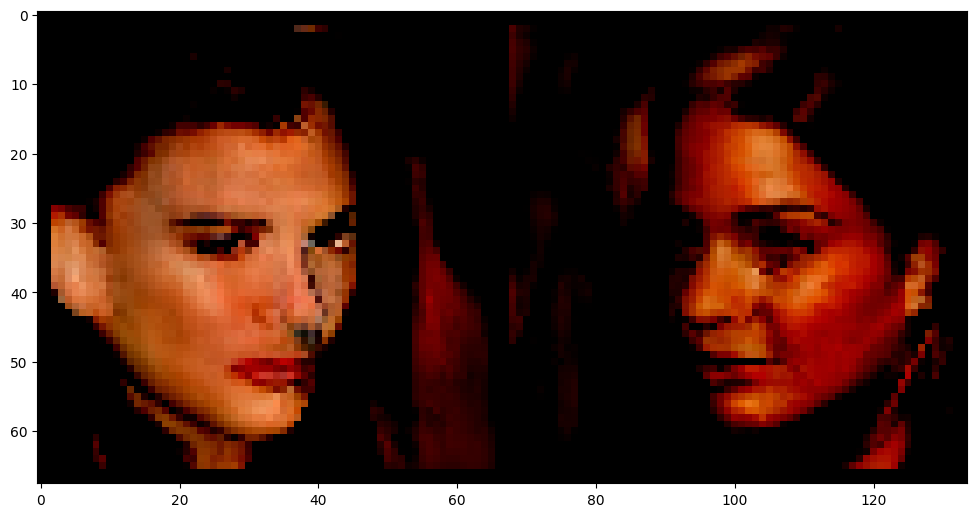

In [21]:
print(generated_images[src_img_idx].shape)
im1 = F.interpolate(generated_images[src_img_idx].unsqueeze(0), size=(64,64))
im2 = F.interpolate(generated_images[target_img_idx].unsqueeze(0), size=(64,64))
print(im1.shape, im2.shape)
show(make_grid(torch.cat([im1, im2], 0)))
im1, im2 = (I.reshape(3,-1,1) for I in (im1.numpy(), im2.numpy()))



In [22]:
img_size = (64, 64)
epsilon = 20.0

print("Preparing transportation cost matrix...")
C = generate_metric(img_size)
Q = np.concatenate([im1, im2], axis=-1)
Q, max_val, Q_counts = preprocess_Q(Q)
out_ours = []
out_GAN = []
out_OT = []

print("Computing transportation plan...")
for dim in range(3):
    print(f"Color space {dim+1}/3")
    out_OT.append([])
    P = sinkhorn(Q[dim,:,0], Q[dim,:,1], C, img_size[0], img_size[1], epsilon)
    for t in tqdm(np.linspace(0,1,L)):
        out_OT[-1].append(max_val - generate_interpolation(img_size[0],img_size[1],P,t)*((1-t)*Q_counts[dim,0,0] + t*Q_counts[dim,0,1]))
out_OT = [np.stack(im_channels, axis=0) for im_channels in zip(*out_OT)]

Preparing transportation cost matrix...
Computing transportation plan...
Color space 1/3
Iteration 50. Sinkhorn convergence: 3.13E-01 ( > 1e-07)
Iteration 100. Sinkhorn convergence: 5.19E-07 ( > 1e-07)
Iteration 150. Sinkhorn convergence: 7.19E-08 (Converged!)



Color space 2/3
Iteration 50. Sinkhorn convergence: 2.74E-01 ( > 1e-07)
Iteration 100. Sinkhorn convergence: 3.55E-01 ( > 1e-07)
Iteration 150. Sinkhorn convergence: 2.13E-02 ( > 1e-07)
Iteration 200. Sinkhorn convergence: 2.26E+02 ( > 1e-07)
Iteration 250. Sinkhorn convergence: 1.18E+02 ( > 1e-07)
Iteration 300. Sinkhorn convergence: 1.80E-02 ( > 1e-07)
Iteration 350. Sinkhorn convergence: 2.33E-06 ( > 1e-07)
Iteration 400. Sinkhorn convergence: 7.32E-09 (Converged!)



Color space 3/3
Iteration 50. Sinkhorn convergence: 3.25E-02 ( > 1e-07)
Iteration 100. Sinkhorn convergence: 2.51E-02 ( > 1e-07)
Iteration 150. Sinkhorn convergence: 6.78E-01 ( > 1e-07)
Iteration 200. Sinkhorn convergence: 1.77E-01 ( > 1e-07)
Iteration 250. Sinkhorn convergence: 5.88E-03 ( > 1e-07)
Iteration 300. Sinkhorn convergence: 2.71E-08 (Converged!)


In [24]:
import torch.nn as nn
def project_on_generator(G: nn.Module, target_image: np.ndarray, iters=500, eta: float=1e-9, eps: float=1e-4, z_dim: int=512
                         ) -> Tuple[np.ndarray, torch.Tensor]:
    
    # target_image (3, 64, 64)
    # image (3, 256, 256)
    image = F.interpolate(torch.tensor(target_image).unsqueeze(0), (256, 256))     
    #print(image.shape)
    # use grad
    z_0 = torch.zeros((1, z_dim), requires_grad=True)
    pre_loss = 10000000
    trange = tqdm(range(iters))
    for i in trange:
        z_0.retain_grad()
        if z_0.grad is not None:
            z_0.grad.detach_()
            z_0.grad.zero_()

        loss_r1 = F.mse_loss(image, model.netG(z_0))
        loss_r1.backward()
        cur_grad = z_0.grad
        z_0 = z_0 - eta*cur_grad
        trange.set_postfix({"loss_r1":loss_r1.item(), "z0_norm":z_0.norm().item(), "grad_norm":eta*cur_grad.norm().item(), "residual":abs(pre_loss - loss_r1.item())})
        if(abs(pre_loss - loss_r1.item()) < eps):
            break
        pre_loss = loss_r1.item()
        
    return model.test(z_0).squeeze(0), z_0

In [25]:
print("Computing GAN projections...")
iters = 5
# Project OT results on GAN
GAN_projections = []
for I in out_OT:
    I_, z = project_on_generator(model, I)
    GAN_projections.append((I_, z))

GAN_projections_images, GAN_projections_noises = zip(*GAN_projections)
out_ours = GAN_projections_images

Computing GAN projections...


In [26]:
# Linearly interpolate GAN's latent space
noise1 = GAN_projections_noises[0]
noise2 = GAN_projections_noises[-1]
out_GAN = []
GAN_interp_noises = []
for t in np.linspace(0,1,L):
    t = float(t)  # cast numpy object to primative type
    z_inter = (1-t)*noise1 + t*noise2
    GAN_interp_noises.append(z_inter)
    GAN_image = model.test(z_inter).cpu().data
    GAN_image = F.interpolate(GAN_image, img_size).squeeze(0)

    GAN_image = GAN_image.numpy()
    out_GAN.append(GAN_image)

In [27]:
img_size = (64,64)
out_ours = [F.interpolate(i.unsqueeze(0), img_size).squeeze(0) for i in out_ours]

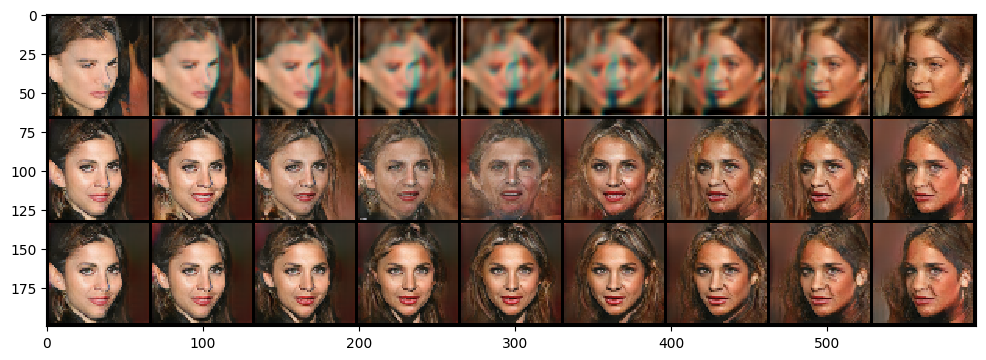

In [28]:
final_OT = torch.stack([torch.Tensor(im).reshape(3,*img_size) for im in out_OT])
final_ours = torch.stack([torch.Tensor(im).reshape(3,*img_size) for im in out_ours])
final_GAN = torch.stack([torch.Tensor(im).reshape(3,*img_size) for im in out_GAN])
show(make_grid(torch.cat([final_OT,final_ours, final_GAN], dim=0), 
        normalize=True,
        nrow=L,
        range=(-1.,1.)))
#         range=(-0.5,0.5)))

In [29]:
# ============ ablation study ================

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


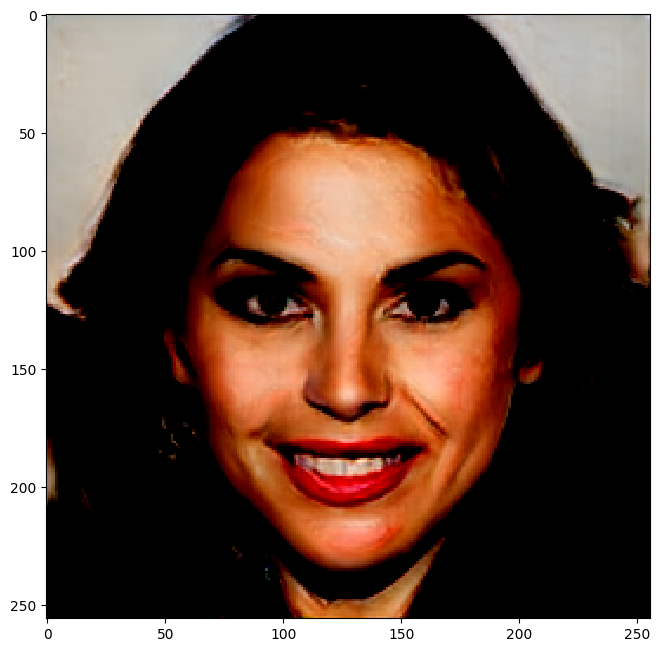

In [30]:
# This is origin zero image

origin_zero = torch.zeros((1, 512))
origin_image = model.test(origin_zero)
show(make_grid(origin_image))

In [39]:
# starts from previous z

def project_on_generator_from_z(G: nn.Module, target_image: np.ndarray, previous_z, iters=500, eta: float=1e-9, eps: float=1e-4, z_dim: int=512
                         ) -> Tuple[np.ndarray, torch.Tensor]:
    
    # target_image (3, 64, 64)
    # image (3, 256, 256)
    image = F.interpolate(torch.tensor(target_image).unsqueeze(0), (256, 256))     
    #print(image.shape)
    # use grad
    z_0 = previous_z
    z_0.requires_grad = True
    pre_loss = 10000000
    trange = tqdm(range(iters))
    for i in trange:
        z_0.retain_grad()
        if z_0.grad is not None:
            z_0.grad.detach_()
            z_0.grad.zero_()

        loss_r1 = F.mse_loss(image, model.netG(z_0))
        loss_r1.backward()
        cur_grad = z_0.grad
        z_0 = z_0 - eta*cur_grad
        trange.set_postfix({"loss_r1":loss_r1.item(), "z0_norm":z_0.norm().item(), "grad_norm":eta*cur_grad.norm().item(), "residual":abs(pre_loss - loss_r1.item())})
        if(abs(pre_loss - loss_r1.item()) < eps):
            break
        pre_loss = loss_r1.item()
        
    return model.test(z_0).squeeze(0), z_0.detach()

In [40]:
print("Computing GAN projections...")
iters = 5
z_dim = 512
# Project OT results on GAN
GAN_projections = []
previous_z = torch.zeros((1, z_dim))
for I in out_OT:
    I_, z = project_on_generator_from_z(model, I, previous_z)
    GAN_projections.append((I_, z))
    previous_z = z
GAN_projections_images, GAN_projections_noises = zip(*GAN_projections)
out_ours = GAN_projections_images

Computing GAN projections...


In [41]:
# Linearly interpolate GAN's latent space
noise1 = GAN_projections_noises[0]
noise2 = GAN_projections_noises[-1]
out_GAN = []
GAN_interp_noises = []
for t in np.linspace(0,1,L):
    t = float(t)  # cast numpy object to primative type
    z_inter = (1-t)*noise1 + t*noise2
    GAN_interp_noises.append(z_inter)
    GAN_image = model.test(z_inter).cpu().data
    GAN_image = F.interpolate(GAN_image, img_size).squeeze(0)

    GAN_image = GAN_image.numpy()
    out_GAN.append(GAN_image)

In [42]:
img_size = (64,64)
out_ours = [F.interpolate(i.unsqueeze(0), img_size).squeeze(0) for i in out_ours]

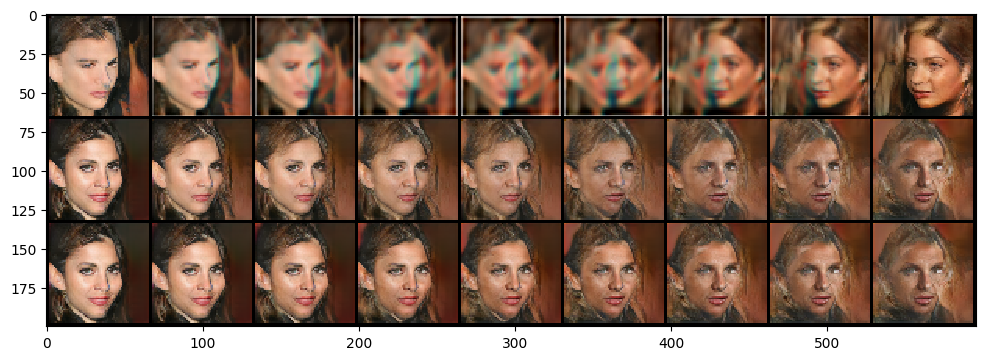

In [43]:
final_ours = torch.stack([torch.Tensor(im).reshape(3,*img_size) for im in out_ours])
final_GAN = torch.stack([torch.Tensor(im).reshape(3,*img_size) for im in out_GAN])
show(make_grid(torch.cat([final_OT,final_ours, final_GAN], dim=0), 
        normalize=True,
        nrow=L,
        range=(-1.,1.)))

In [44]:
# ============ Walk from Interpolation ==============

In [45]:
print("Computing GAN projections src and target for interoplation...")
iters = 5
# Project OT results on GAN
I_src, z_src = project_on_generator(model, out_OT[0])
I_target, z_target = project_on_generator(model, out_OT[-1])   


Computing GAN projections src and target for interoplation...


In [46]:
# Linearly interpolate GAN's latent space
noise1 = z_src
noise2 = z_target
out_GAN = []
GAN_interp_noises = []
for t in np.linspace(0,1,L):
    t = float(t)  # cast numpy object to primative type
    z_inter = (1-t)*noise1 + t*noise2
    GAN_interp_noises.append(z_inter)
    GAN_image = model.test(z_inter).cpu().data
    GAN_image = F.interpolate(GAN_image, img_size).squeeze(0)

    GAN_image = GAN_image.numpy()
    out_GAN.append(GAN_image)

In [49]:
print("Computing GAN projections...")
iters = 5
z_dim = 512
# Project OT results on GAN
GAN_projections = []
for ct, I in enumerate(out_OT):
    if ct == 0:
        GAN_projections.append((I_src, z_src))
    elif ct == len(out_OT) - 1:
        GAN_projections.append((I_target, z_target))
    else:
        I_, z = project_on_generator_from_z(model, I, GAN_interp_noises[ct].detach())
        GAN_projections.append((I_, z))
GAN_projections_images, GAN_projections_noises = zip(*GAN_projections)
out_ours = GAN_projections_images

Computing GAN projections...


In [59]:
img_size = (64,64)
out_ours = [F.interpolate(i.unsqueeze(0), img_size).squeeze(0) for i in out_ours]

In [60]:
print(len(out_ours))
print(len(out_GAN))
print(out_ours[2].shape)
print(out_GAN[0].shape)

9
9
torch.Size([3, 64, 64])
(3, 64, 64)


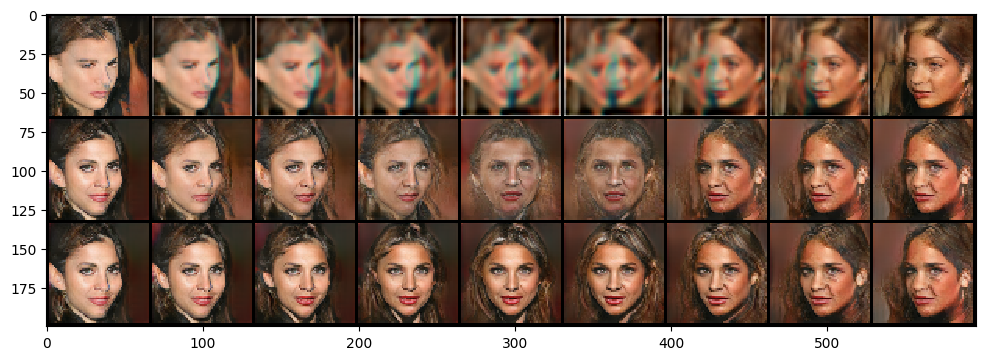

In [61]:
final_ours = torch.stack([torch.Tensor(im).reshape(3,*img_size) for im in out_ours])
final_GAN = torch.stack([torch.Tensor(im).reshape(3,*img_size) for im in out_GAN])
show(make_grid(torch.cat([final_OT,final_ours, final_GAN], dim=0), 
        normalize=True,
        nrow=L,
        range=(-1.,1.)))

In [72]:
for ct,img in enumerate(final_GAN):
    torchvision.utils.save_image(img, "GAN_latent_space"+str(ct)+".png", normalize=True, nrow=L,
        range=(-1.,1.))
torchvision.utils.save_image(final_GAN, fp = "GAN_latent_space_all.png", normalize=True, nrow=L,
        range=(-1.,1.))

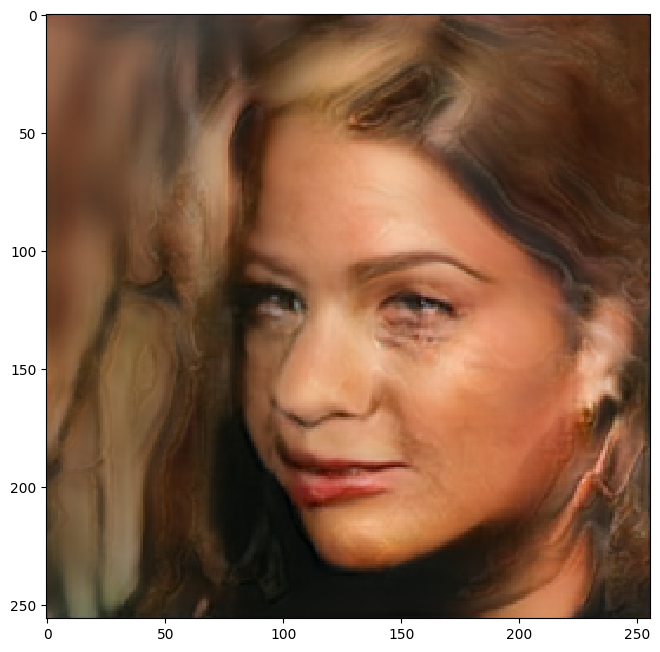

In [69]:
show(make_grid(generated_images[target_img_idx], normalize=True, range=(-1.,1.)))